# 2022-07-19 First tests with decision evidence accumulation

Results below are for commit: ###

(Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

## Definition

Adding a new optional model assumption `oDA`. When enabled, action evidence $\xi_a$ is accumulated for each action alternative $a$:

$$
\frac{\mathrm{d}\xi_a}{\mathrm{d}t}(k) = \Delta V_a(k) - \gamma \xi_a(k-1),
$$

where $\gamma$ is a leakage (forgetting) parameter, and where the decision is made once $\xi_a > \xi_\mathrm{th}$. To set $\gamma$ and $\xi_\mathrm{th}$, I define the free model parameters 
$T_\xi$, the time to decision threshold when $\Delta V_a = V_\mathrm{free}$, and $C_\xi$, a fraction such that $\Delta V_a = C_\xi V_\mathrm{free}$ is the highest constant surplus action value for which the decision evidence accumulation will never reach threshold. To get $\gamma$ and $\xi_\mathrm{th}$ from $T_\xi$ and $C_\xi$, we can note that for an initial $\xi_a = 0$, a constant $\Delta V_a$, and a small simulation time step $\Delta t$, the solution to the evidence accumulation equation above is:

$$
\xi_a(t) = \frac{\Delta V_a}{\gamma}\left( 1 - e^{-\gamma t} \right)
$$

which converges toward $\Delta V_a / \gamma$. Therefore, setting

$$
\xi_\mathrm{th} = \frac{C_\xi V_\mathrm{free}}{\gamma}
$$

ensures that the decision threshold will be reached within finite time for any constant $\Delta V_a > C_\xi V_\mathrm{free}$, but not for $\Delta V_a = C_\xi V_\mathrm{free}$. Furthermore, by solving the equation $\xi_a(t = T_\xi) = \xi_\mathrm{th}$, we get:

$$
\gamma = -\frac{1}{T_\xi} \ln{(1 - C_\xi)}
$$

The code below is just to verify these calculations, for $C_\xi =$ 0.1 and $T_\xi =$ 0.3 s, and an arbitrarily chosen $V_\mathrm{free} =$ 5 (changing this value doesn't affect the simulation results; only the scaling of the $\xi$-axis):

With C_xi = 0.1 and T_xi = 0.3 s (and V_free arbitrarily set to 5) we get:
gamma = 0.3512, xi_th = 1.4237

*** With DeltaV = 0.1 x V_free = 0.5 ***
Decision threshold not reached.


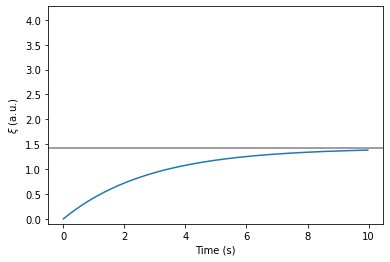


*** With DeltaV = 0.2 x V_free = 1.0 ***
Decision threshold reached at time 1.98 s.


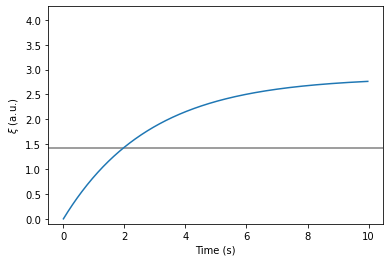


*** With DeltaV = 1 x V_free = 5 ***
Decision threshold reached at time 0.30 s.


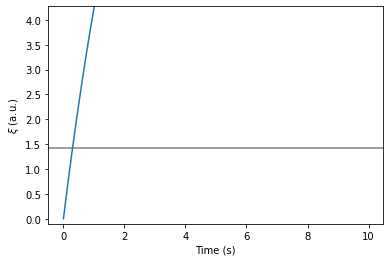

In [1]:
import numpy as np
import matplotlib.pyplot as plt

TIME_STEP = 0.025
END_TIME = 10
TIME_STAMPS = np.arange(0, END_TIME, TIME_STEP)
N_TIME_STEPS = len(TIME_STAMPS)

# just setting some arbitrary V_free
V_FREE = 5

# free model parameters
C_XI = 0.1
T_XI = 0.3

# derived model parameters
GAMMA = -np.log(1 - C_XI) / T_XI
XI_TH = C_XI * V_FREE / GAMMA

print(f'With C_xi = {C_XI} and T_xi = {T_XI} s (and V_free arbitrarily set to {V_FREE}) we get:')
print(f'gamma = {GAMMA:.4f}, xi_th = {XI_TH:.4f}')

# simulate for different DeltaV
for fract in (C_XI, 2*C_XI, 1):
    deltaV = fract * V_FREE
    print(f'\n*** With DeltaV = {fract} x V_free = {deltaV} ***')
    xis = np.full(N_TIME_STEPS, np.nan)
    xis[0] = 0
    for i_time_step in range(1, N_TIME_STEPS):
        dxidt = deltaV - GAMMA * xis[i_time_step-1]
        xis[i_time_step] = xis[i_time_step-1] + TIME_STEP * dxidt
    idx_over_thresh = np.nonzero(xis > XI_TH)[0]
    if len(idx_over_thresh) == 0:
        print('Decision threshold not reached.')
    else:
        print(f'Decision threshold reached at time {TIME_STAMPS[idx_over_thresh[0]]:.2f} s.')
    plt.axhline(XI_TH, c='gray')
    plt.plot(TIME_STAMPS, xis)
    plt.xlabel('Time (s)')
    plt.ylabel(r'$\xi$ (a.u.)')
    plt.ylim(-0.1, 3 * XI_TH)
    plt.show()


## Some implementation notes

The `oDA` assumption is implemented to be compatible with `oEA`, i.e., both assumption can be enabled at the same time. If they are both enabled, action values get accumulated (/low-pass filtered) with time constant $T$ as usual for `oEA`, but the thresholding by $\Delta V_\mathrm{th}$ is not done; the action decision is made using the accumulated action evidence $\xi_a$ of the `oDA` assumption as described above. In other words, the free parameter $\Delta V_\mathrm{th,rel}$ does not have any effect on `oEAoDA` model variants.

Also `oAN` is compatible with `oDA`. Its implementation has not changed, i.e., just as before the value noise gets added in the "noisy low-pass filter" used by both the `oEA` and `oAN` assumptions (with low-pass filter time constant $\Delta t$ if `oEA` is not enabled). 

## Testing the new assumption

Just a first run of the new code - clearly not working as intended. 

The text output of action $\xi_a$s below the plots show that decision evidence accumulation is happening - but much slower than I planned. The reason is (of course) that I am using $\Delta V_a$ to determine the evidence accumulation rate, and $\Delta V_a$ is generally much much smaller than $V_\mathrm{free}$.

Overall after mulling over the `oDA` assumption a bit further, I think it may be more sensible to opt for a simpler one-sided accumulator with a reflecting boundary at zero $\xi_a$ instead, without the forgetting (except the forgetting that happens at the zero boundary). This would only have a single decision threshold as a free parameter. This will be my next step. (I have actually written some first code, but it is commented out in this commit.)

['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework', 'C:\\GITHUB\\COMMOTIONSFramework/SCPaper']

Initial car distance 30 m:


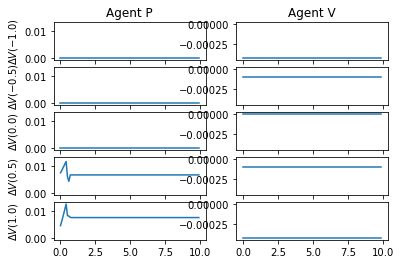

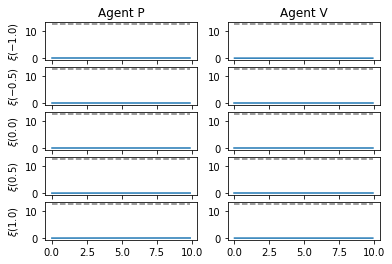

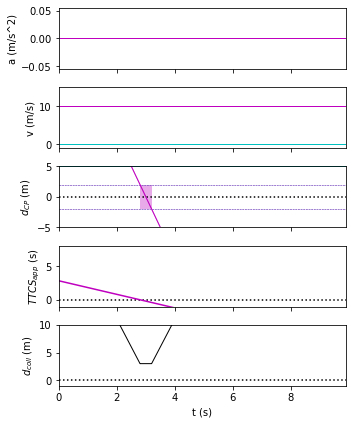


Initial car distance 40 m:


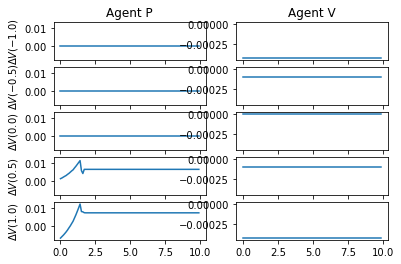

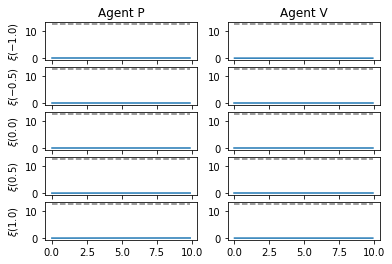

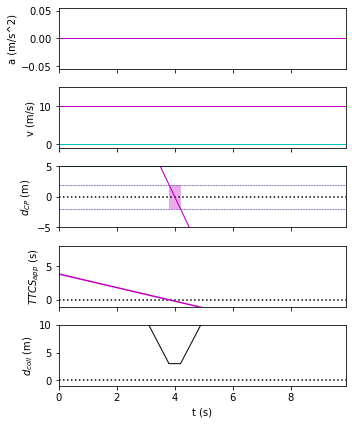


Initial car distance 50 m:


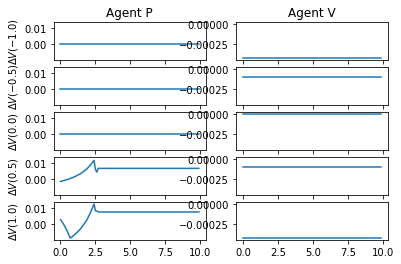

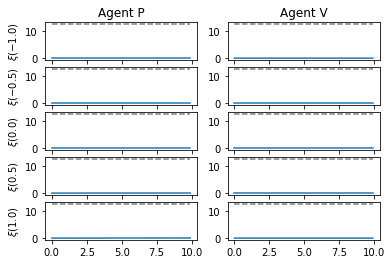

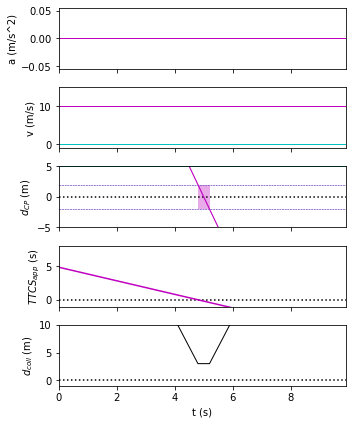

In [2]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
for folder_to_add in ('', '/SCPaper'):
    path_to_add = parent_path + folder_to_add
    if not (path_to_add in sys.path):
        sys.path.append(path_to_add)
print(sys.path)

import sc_scenario

optional_assumptions = sc_scenario.get_assumptions_dict(
    default_value=False, oVA=True, oDA=True)
sims = sc_scenario.run_test_scenarios(optional_assumptions=optional_assumptions, 
                                      plot_act_evidences=True, plot_surpl_act_vals=True)

In [4]:
ped_agent = sims[0].agents[0]
print(f'Pedestrian agent V_free = {ped_agent.V_free:.2f}')
print('First ten time steps of xi_a for all five action alternatives:')
print(ped_agent.states.action_evidence[:, 0:10])

Pedestrian agent V_free = 43.28
First ten time steps of xi_a for all five action alternatives:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00074287 0.00156842 0.0024857  0.00349448 0.00459312 0.00510729
  0.00545131 0.00602396 0.00658682 0.00714006]
 [0.00045591 0.00108179 0.00189403 0.00289409 0.00409161 0.00484385
  0.00556668 0.00622884 0.00687355 0.00750723]]


## Model unit tests

Also just rerunning the model unit tests, now extended with a couple of oDA ones.



***** Base model, just startup *****


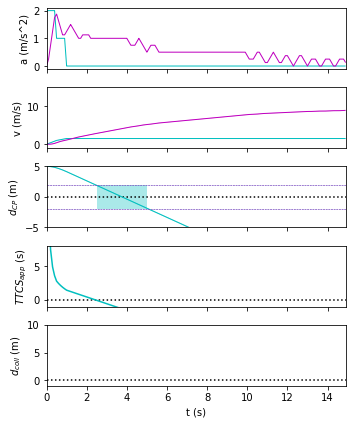



***** Base model, baseline kinematics *****

Initial car distance 30 m:


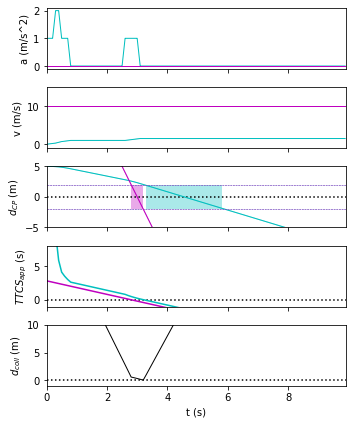


Initial car distance 40 m:


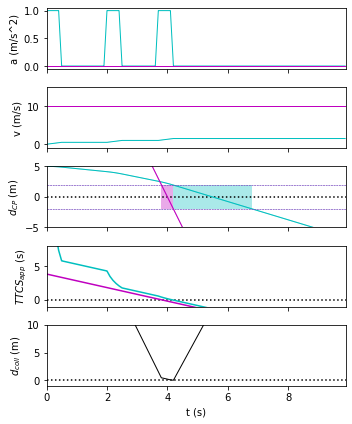


Initial car distance 50 m:


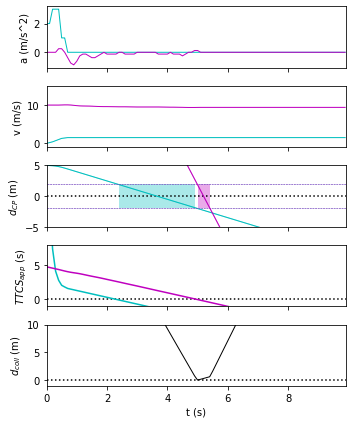



***** Enabling behaviour observation assumptions *****

Turning on oBEo:


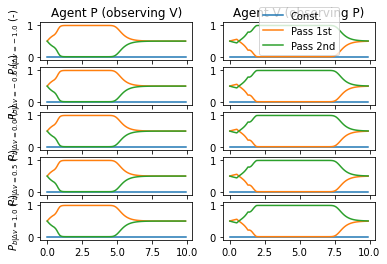

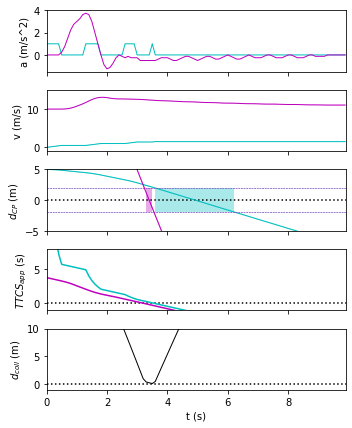


Turning on oBEv:


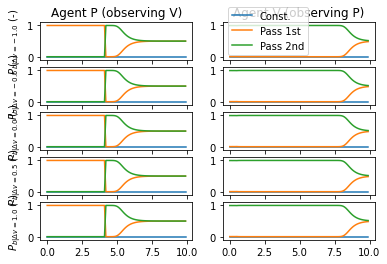

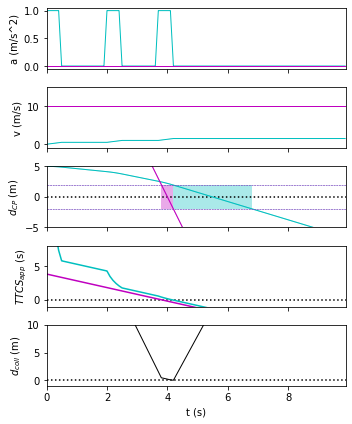


Turning on oAI:


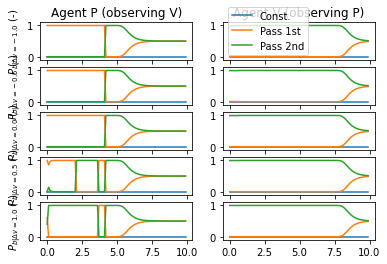

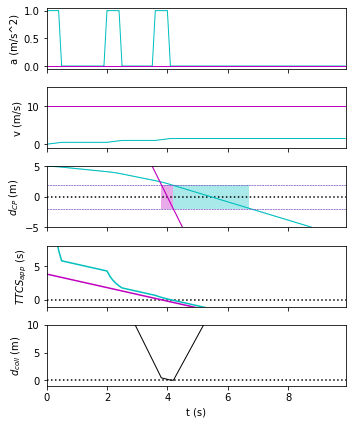



***** Enabling value accumulation *****

Initial car distance 30 m:


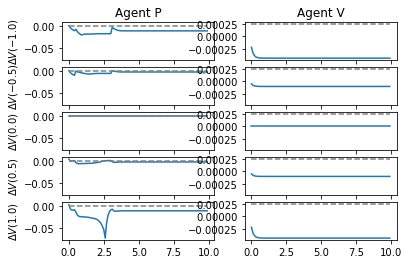

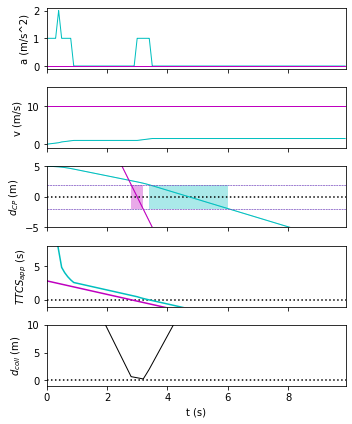


Initial car distance 50 m:


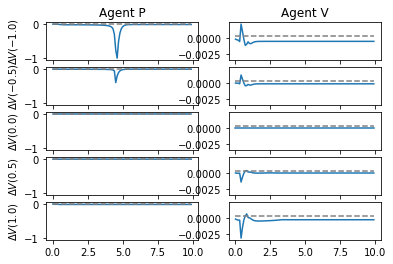

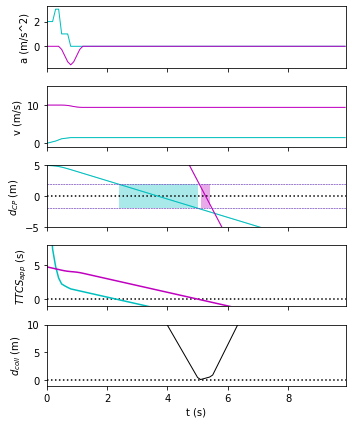



***** Enabling decision evidence accumulation *****

Initial car distance 30 m:


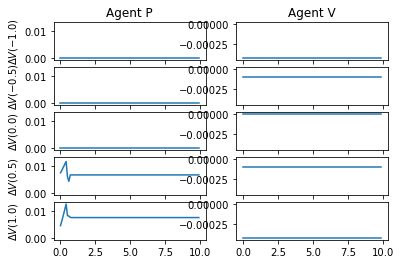

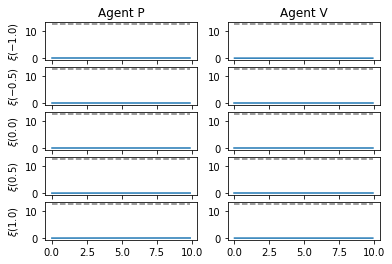

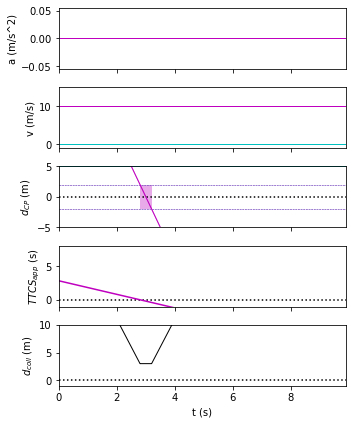


Initial car distance 50 m:


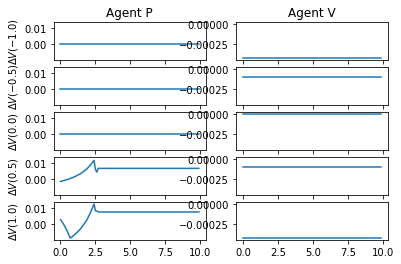

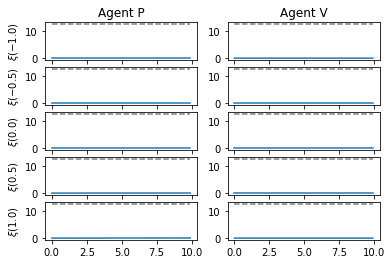

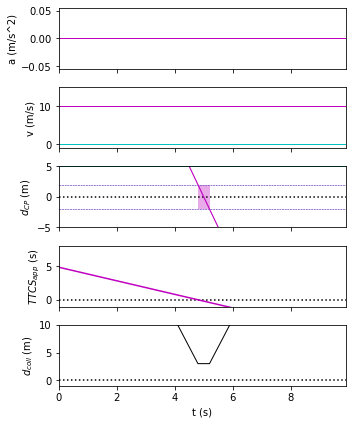

In [5]:
%run ../sc_scenario.py